In [30]:
!uname -a

Linux claritytrec 4.4.0-28-generic #47-Ubuntu SMP Fri Jun 24 10:09:13 UTC 2016 x86_64 x86_64 x86_64 GNU/Linux


In [ ]:
import pandas as pd
import gzip as gz
import json


fname = '/home/alawlor/data/amazon_reviews/aggressive_dedup.json.gz'

def _gen():
    with gz.open(fname, 'rb') as f:
        for i,line in enumerate(f):
            obj = json.loads(line)
            #print(obj)
            yield dict(reviewerID=obj['reviewerID'], asin=obj['asin'], reviewText=obj['reviewText'])
            #return
            
df = pd.DataFrame(_gen())
df.to_csv("userItemReview", sep=',', encoding='utf-8')
print("Done!")

In [ ]:
df.head(1000)

In [ ]:
df.to_pickle("userItemReview.pkl")
print("Done!")

# Load Data

## Read Data

In [9]:
import pandas as pd
dataset=[]
dataset = pd.read_pickle("userItemRating.pkl")

The dataset we dealing with is loaded here, through reading from a pickle file stored on the disk.

## Dataset Report

In [19]:
def data_report(df=None):
    users = df.reviewerID.unique()
    items= df.asin.unique()
    ratings= df.overall.unique()
    n_users= len(users)
    n_items= len(items)
    n_reviews= len(df)
    density = ((n_reviews)/(n_users*n_items))
    meanReviewsPerUser=df['reviewerID'].value_counts().mean()
    meanReviewsPerItem=df['asin'].value_counts().mean()
    meanRating=df['overall'].mean()
    print("#Users: ",n_users,"        #Items: ",n_items,"        #Reviews: ",n_reviews,"        Density: ",density,"%")
    print("Mean reviews per User: ",meanReviewsPerUser,"   Mean reviews per Item: ",meanReviewsPerItem,"   Mean Rating (Overall): ",meanRating)
    print("Dataset Size: ",len(df),"        #Duplicate Records: ",((len(df))-(len(dataset.drop_duplicates(subset=['asin', 'reviewerID'])))))

data_report(dataset)

#Users:  21137702         #Items:  9857286         #Reviews:  83091702         Density:  3.9878840878490306e-07 %
Mean reviews per User:  3.930971398877702    Mean reviews per Item:  8.429470545949464    Mean Rating (Overall):  4.160582605468835
Dataset Size:  83091702         #Duplicate Records:  255200


The above information obtained as a product of initial computation on the dataset, to get a deeper insight on it.<br/><br/>
The following are the observations:<br/>
<ul>
<li>Total number of unique users in the dataset is: <b>21,137,702.</b> .</li>
<li>Total number of unique items in the dataset is: <b>9,857,286</b> .</li>
<li>Total Reviews/Ratings present in the dataset is: <b>83,091,702</b> .</li>
<li>Number of duplicate reviews present in the dataset is: <b>255,200</b> .</li>
<li>Density of the dataset is the number of cells of the item-user matrix that is populated with data.<br/>
Density of the dataset here is: <b>~3.987884%</b> .</li>
<li>The mean number of reviews given per user in the datset is: <b>3.93097%</b> .</li>
<li>The mean number of reviews received per item in the dataset is: <b>8.42947</b> .</li>
</ul>

## After removing duplicate data

In [4]:
dataset= dataset.drop_duplicates(subset=['asin', 'reviewerID'], keep="last")
#data_report(dataset)

# Plots

## Loading libraries and pre-computing data

After loading the dataset, we conduct various computations over it.

In [5]:
#Load the libraries required
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import plotly as py
import pandas as pd

#Pickle store/load function

def storePickle(df=None,name="temp.pkl"):
    df.to_pickle(name)
    
def loadPickle(name="temp.pkl"):
    df=pd.read_pickle(name)
    return df

#Grouping func

def groupingData(df=None,cols=['n_occurences','n_members']):
    df_Temp=pd.DataFrame(columns=cols)
    colName=list(df)
    df_Temp[cols[0]]=df.groupby(colName[0]).groups.keys()
    df_Temp[cols[1]]=df.groupby(colName[0]).size()
    df_Temp=df_Temp.fillna(0)
    return df_Temp

#Pre-compute the data to be used in plotting
def preCompute(df=None):
    df_grpRevUser = dataset[['reviewerID']].groupby('reviewerID', sort=False).agg({'reviewerID': 'count'})
    df_grpRevItem = dataset[['asin']].groupby('asin', sort=False).agg({'asin': 'count'})
    df_grpRateUser= dataset.groupby(['reviewerID'],sort=False).agg({'overall': 'mean'})
    df_grpRateItem= dataset.groupby(['asin'],sort=False).agg({'overall': 'mean'})
    storePickle(df_grpRevUser,name="grpRevUser.pkl")
    storePickle(df_grpRevItem,name="grpRevItem.pkl")
    storePickle(df_grpRateUser,name="grpRateUser.pkl")
    storePickle(df_grpRateItem,name="grpRateItem.pkl")
    return df_grpRevUser,df_grpRevItem,df_grpRateUser,df_grpRateItem

def loadPreCompute():
    df_grpRevUser=loadPickle(name="grpRevUser.pkl")
    df_grpRevItem=loadPickle(name="grpRevItem.pkl")
    df_grpRateUser=loadPickle(name="grpRateUser.pkl")
    df_grpRateItem=loadPickle(name="grpRateItem.pkl")
    return df_grpRevUser,df_grpRevItem,df_grpRateUser,df_grpRateItem

Here in the function "preCompute", we pass a dataframe (which would be our dataset), and we group the data by reviewers or items.<br/>
On the groups generated we calculated the number of occurences of that element (which signifies number of reviews/ratings against them) and mean of the total ratings against them.<br/>
These values corresponding to their groups are stored in their respective dataframes, which are then returend back to the callee and even stored on the disk in the form of pickle files, that can be utilized to load later instead of undergoing all these process again.

In [8]:
##Execute this to compute and store the groups as pickle
    
%time df_grpRevUser,df_grpRevItem,df_grpRateUser,df_grpRateItem = preCompute(dataset)

CPU times: user 4min 18s, sys: 1min 47s, total: 6min 5s
Wall time: 7min 21s


In [6]:
##Execute this if the pre-computed files are already stored and just need to load it from pickle files.

%time df_grpRevUser,df_grpRevItem,df_grpRateUser,df_grpRateItem= loadPreCompute()

CPU times: user 19.7 s, sys: 5.34 s, total: 25.1 s
Wall time: 28.8 s


## Plotting function
We define a generic plotting function here, that can be utilized to visualize histogram plots.

In [16]:
import numpy as np
import matplotlib as mlib
import matplotlib.pyplot as plt



def plotting(df=None,nbins=1,xmin=None,xmax=None, density=False, xlabel='', ylabel='', logscale=False, cumulative=None ):
    if xmin==None:
        xmin=df.min()
    if xmax==None:
        xmax=(df.max())+1
        
    if density:
        normed = True
        if cumulative==None:
            cumulative=True
    else:
        normed = False
        if cumulative==None:
            cumulative=False
    
    bins=np.arange(xmin,xmax,nbins)
    
    df.hist(bins=bins, normed=normed, cumulative=cumulative, figsize=(10,7))
    mean_val = df.mean().values[0]
    plt.axvline(x=mean_val, color='r', label='Mean of {} = {}'.format(xlabel,mean_val), alpha=0.6)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if logscale:
        plt.yscale('log')
    #y_formatter = plt.ticker.ScalarFormatter(useOffset=False)
    #plt.yaxis.set_major_formatter(y_formatter)
    plt.legend()
    return


## Creating Plots

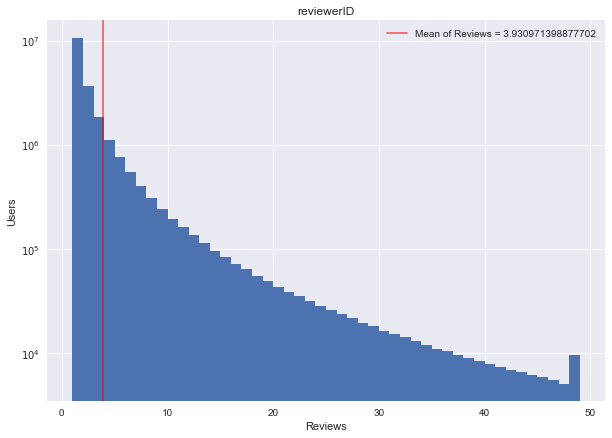

In [7]:
#Call the plotting function
plotting(df_grpRevUser, xmin=1, xmax=50, density=False, logscale=True, xlabel="Reviews", ylabel="Users")

In the histogram above, we can clearly see the following: <br/>
<ul>
<li>Maximum number of users just reviewed only 1 item. The number of users being above 7,000,000.</li>
<li>The mean number of reviews per user in the dataset is 3.93097</li>
</ul>

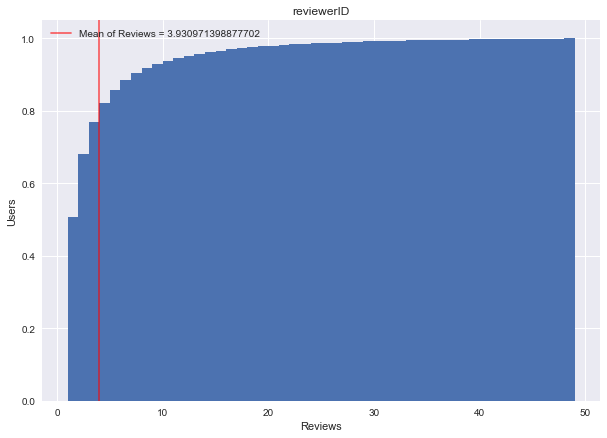

In [8]:
#Call the plotting function

plotting(df_grpRevUser, xmin=1, xmax=50, density=True, logscale=False, xlabel="Reviews", ylabel="Users")

Here in the graph above we can infer the following:<br/>
<ul>
<li>100% of the users has been reached when the number of Reviews is about 48.</li>
<li>A threshold of upto 48 reviews per user can be set as minimum threshold to consider all the users present in the dataset. Helping us to extract a sample of the entire dataset, saving time and memory complexities.</li>
</ul>

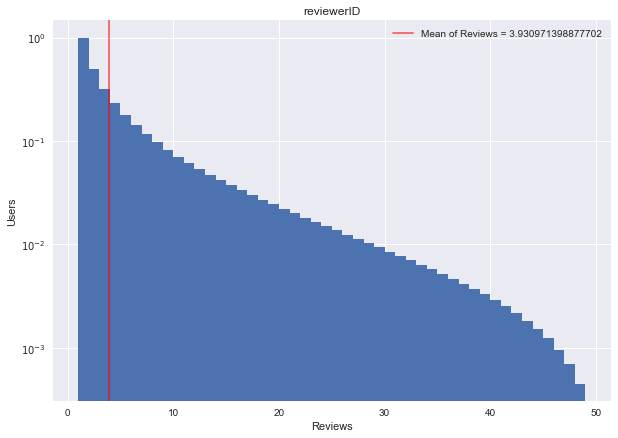

In [9]:
#Call the plotting function

plotting(df_grpRevUser, xmin=1, xmax=50, density=True, logscale=True, xlabel="Reviews", ylabel="Users", cumulative=-1)

<ul>
<li>Here through the graph above we can infer that as we consider setting a threshold on minimum number of reviews per user, as this number increases we see that number of users satisfying this threshold declines gradually.</li>
<li>At minimum reviews of 50, we lose more than 98% of user profile.</li>

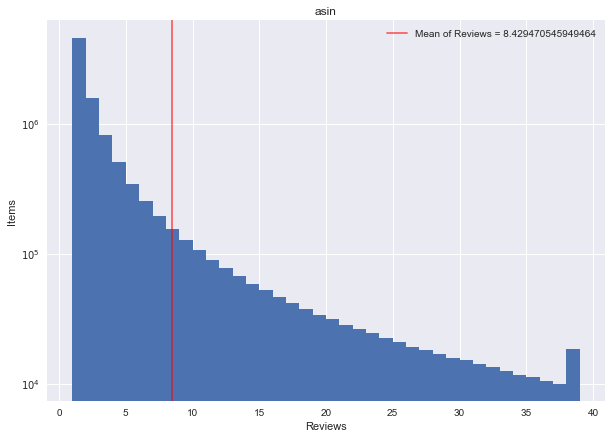

In [10]:
#Call the plotting function

plotting(df_grpRevItem, xmin=1, xmax=40, density=False, logscale=True, xlabel="Reviews", ylabel="Items")

In the histogram above, we can clearly see the following: <br/>
<ul>
<li>Maximum number of items received just 1 review. The number of such items being above 6,700,000.</li>
<li>The mean number of reviews per item in the dataset is 8.42947</li>
</ul>

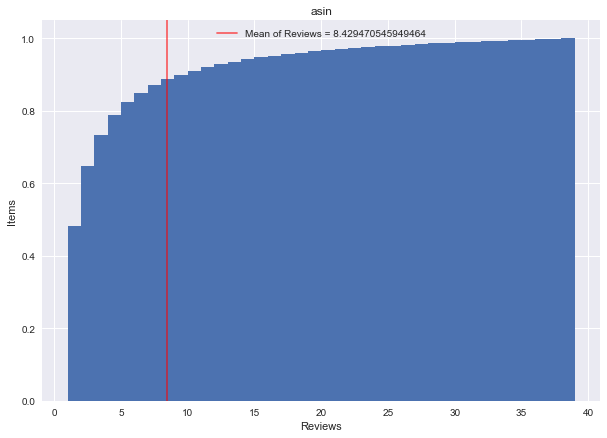

In [11]:
#Call the plotting function

plotting(df_grpRevItem, xmin=1, xmax=40, density=True, logscale=False, xlabel="Reviews", ylabel="Items")

Here in the graph above we can infer the following:<br/>
<ul>
<li>100% of the items has been reached when the number of Reviews is about 38.</li>
<li>A threshold of upto 38 reviews per item can be set as minimum threshold to consider all the users present in the dataset. Helping us to extract a sample of the entire dataset, saving time and memory complexities.</li>
</ul>

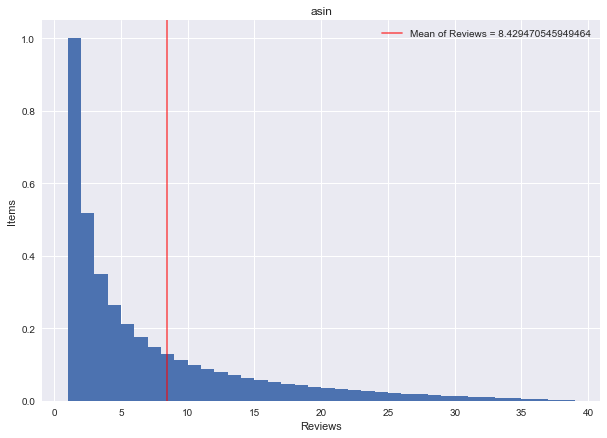

In [12]:
# Call the plotting function
plotting(df_grpRevItem, xmin=1, xmax=40, density=True, logscale=False, xlabel="Reviews", ylabel="Items", cumulative=-1)

<ul>
<li>Here through the graph above we can infer that as we consider setting a threshold on minimum number of reviews per item, as this number increases we see that number of items satisfying this threshold declines gradually.</li>
<li>At minimum reviews of 38-39, we lose about 98-99% of item profiles.</li>

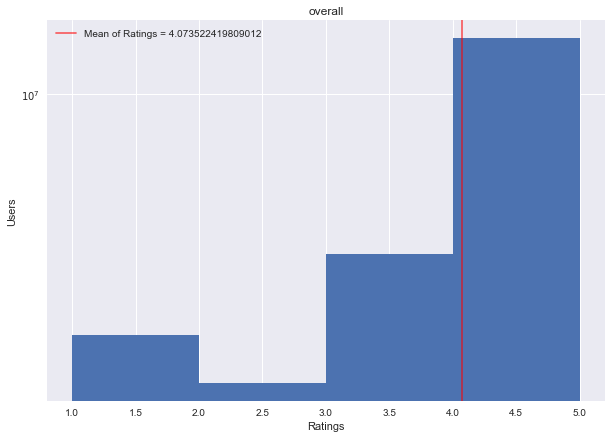

In [13]:
#Call the plotting function

plotting(df_grpRateUser, density=False, logscale=True, xlabel="Ratings", ylabel="Users")

Here fromt he histogram above, we can infer the following:<br/>
<ul>
<li>A paramount of users gave items a maximum rating, i.e. 4-5 "stars".</li>
<li>If we compute the mean of the total ratings given by a user then the mean computed is 4.0735.</li>
<li>The mean being inclined to the positive side infers that most of the items were good, and these users liked it.</li>

Average rating per user

$$
<R_{U}> = \frac{1}{|R_{U}|}\sum_{R_{i} \in U} Rating(R_{i}) 
$$

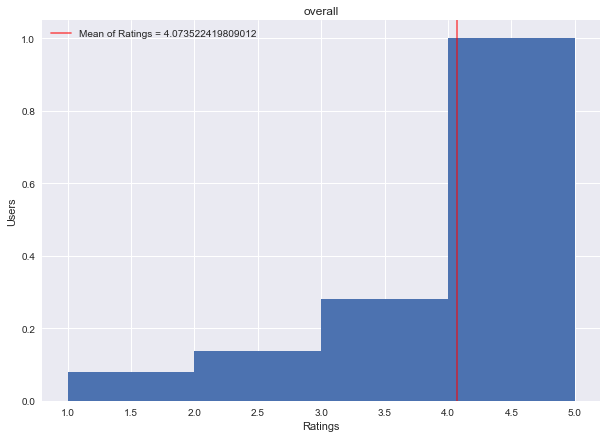

In [14]:
#Call the plotting function

plotting(df_grpRateUser, density=True, logscale=False, xlabel="Ratings", ylabel="Users")

Here in the graph above we can infer the following:<br/>
<ul>
<li>100% of the users has been reached when we consider mean rating of 4.0 .</li>
<li>A threshold of upto 38 reviews per item can be set as minimum threshold to consider all the users present in the dataset. Helping us to extract a sample of the entire dataset without any leftover user, which saves us from time and memory complexities.</li>
</ul>

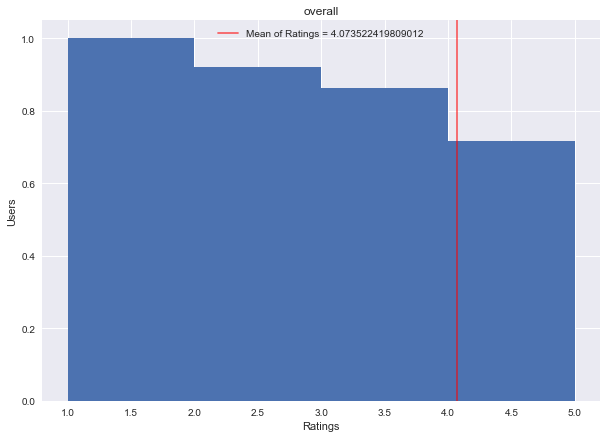

In [15]:
#Call the plotting function

plotting(df_grpRateUser, density=True, logscale=False, xlabel="Ratings", ylabel="Users",cumulative=-1)

<ul>
<li>Here through the graph above we can infer that as we consider setting a threshold on mean rating by a user; as we increase the threshold we see that number of items satisfying this threshold declines gradually.</li>
<li>At minimum mean rating of 4.0, we lose about 70% of the user profiles.</li>

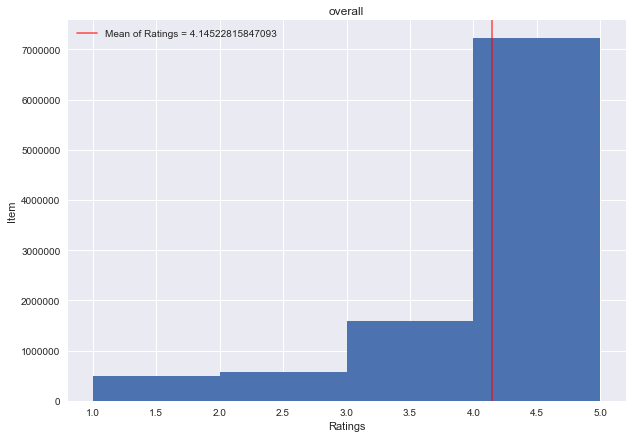

In [16]:
#Call the plotting function

plotting(df_grpRateItem, density=False, logscale=False, xlabel="Ratings", ylabel="Item")

Here fromt he histogram above, we can infer the following:<br/>
- jiij
- ujuj

<ul>
<li>A paramount of items received a maximum rating, i.e. 4-5 "stars". Which validates our above inference of user rating majority of items as so.</li>
<li>If we compute the mean of the total ratings received by an item, then the mean computed is 4.145228.</li>
<li>The mean being inclined to the positive side infers that most of the items were reviewed positively, and the users really liked it.</li>

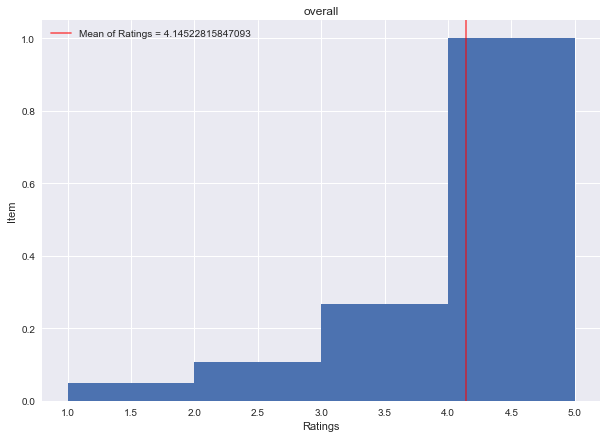

In [17]:
#Call the plotting function

plotting(df_grpRateItem, density=True, logscale=False, xlabel="Ratings", ylabel="Item")

Here in the graph above we can infer the following:<br/>
<ul>
<li>100% of the items has been reached when we consider mean rating of 4.0 .</li>
<li>A threshold of upto a mean rating of 4.0 per item can be set as minimum threshold to consider all the items present in the dataset. Helping us to extract a sample of the entire dataset without any leftover item, which saves us from time and memory complexities.</li>
</ul>

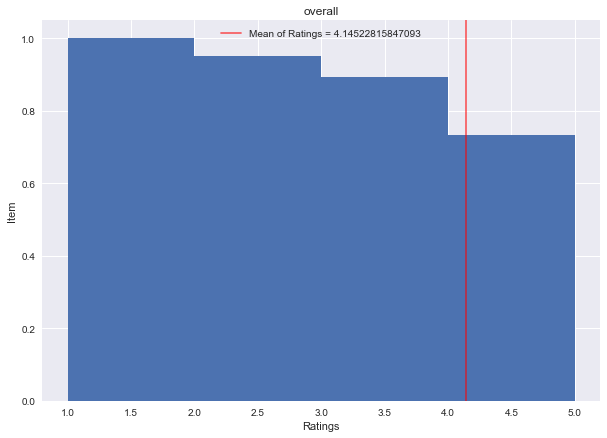

In [18]:
#Call the plotting function

plotting(df_grpRateItem, density=True, logscale=False, xlabel="Ratings", ylabel="Item",cumulative=-1)

<ul>
<li>Here through the graph above we consider setting a threshold on mean rating received by an item; as we increase the threshold we see that number of items satisfying this threshold declines gradually.</li>
<li>At minimum mean rating of 4.0, we lose about 75% of the item profiles.</li>

In [ ]:
import scipy.stats as stats
import pylab as pl
h = sorted(list(dataset['overall']))
fit = stats.norm.pdf(h, np.mean(h), np.std(h))  #this is a fitting indeed
pl.plot(h,fit,'-o')
pl.hist(h,normed=True)      #use this to draw histogram of your data
pl.show()

In [19]:
df_Temp=groupingData(df_grpRateUser,cols=['reviews','n_users'])

# Data Sampling

In [10]:
df_sample=dataset.head(100000)

In [11]:
def sample(df=None, rmin=None, rmax=None, colName="reviewerID"):
    
    df_Temp=df.groupby(colName, sort=False).agg({colName: 'count'})
    
    if rmin==None:
        rmin=df_Temp[colName].min()
    if rmax==None:
        rmax=df_Temp[colName].max()
        
    df_Temp=df_Temp.loc[(df_Temp[colName]>=rmin) & (df_Temp[colName]<=rmax)]
    idList=list(df_Temp.index)
    
    df=df.loc[df[colName].isin(idList)]
    return df

In [12]:
df_sample=sample(df_sample,rmin=2,rmax=4, colName="reviewerID")

In [ ]:
df_sample.head(1000)

# Word Processing

In [12]:
#Load the dataset containg user-item-text values
import pandas as pd
dataset = pd.read_csv('userItemReview.csv',names=['asin','reviewText','reviewerID'], nrows=10000, skiprows=1)

## Preprocessing

Below is the functions declared that would pre-process the text corpus.
The following are the steps taken:

Tokkenization: The raw text is coverted into tokens, i.e broken down into words.

Lemmatisation: WordNetLemmatizer was used to conduct this step. It breaks down a word into its canonical form.

Stop-word removal: Removing stopwords from the text. Stopwords are frequently occurring words that does not add any great meaning to the text. Eg: The, is, etc.

Low frequency filtering: Removing terms that occurred less frequent over all the article.


In [34]:
import re
import nltk
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()

#Thisfunction is declared to preprocess the data, to be used later for TF-IDF
def preprocess(text):
    # tokenize and remove anything else than unicode character
    words = re.findall(r'\w+', text,flags = re.UNICODE)
    lowerwords=[x.lower() for x in words if len(x) > 1] #converting words into lowercase
    #Lemmatization of each word inside the corpus
    lemmatized_words = [lemmatizer.lemmatize(t) for t in lowerwords]
    return lemmatized_words

In [55]:
#Countvectorizer to count the occurence of terms in the documents
count_vectorizer = CountVectorizer(stop_words="english",min_df=0.02,max_df=0.8,tokenizer=preprocess,ngram_range=(1,3))
data_count = count_vectorizer.fit_transform(dataset['reviewText'])
term_matrix= pd.DataFrame(data_count.toarray(), columns=count_vectorizer.get_feature_names())
print(data_count.shape)

(10000, 146)


In [56]:
term_matrix.head(10)

,34,able,actually,amazing,amazon,arrived,author,away,awesome,bad,...,wanted,way,wear,week,wish,work,work great,worth,written,year
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,1,...,0,0,2,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In information retrieval, tf–idf, short for term frequency–inverse document frequency, is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus. It is often used as a weighting factor in information retrieval, text mining, and user modeling. The tf-idf value increases proportionally to the number of times a word appears in the document, but is often offset by the frequency of the word in the corpus, which helps to adjust for the fact that some words appear more frequently in general.

The max_df is the maximum number of documents a term should come in i.e. those terms are removed whihc have higher document frequency then the set threshold frequency.

The min_df is set at 0.03 i.e. only those terms or phrases would be considered whihc comes in more than 3% of the documents.

The ngram_range is set at 3 i.e. maximum of 3 terms which comes together and are important to a document would be considered.

In [ ]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.3,min_df=0.03, stop_words='english',use_idf=True, tokenizer=preprocess, ngram_range=(1,3))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(dataset['reviewText'])

from sklearn.metrics.pairwise import cosine_similarity
dist = 1 - cosine_similarity(tfidf_matrix)

#store the output from the above step in pandas to represent it as document term matrix.
term_matrix_tfidf = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names())
#Prints the shape of resultant matrix
print(tfidf_matrix.shape)

In [53]:
#Prints the document term matrix with TF-IDF weights words
term_matrix_tfidf.head(10)

,34,amazing,awesome,best,better,big,bit,book,bought,buy,...,used,using,ve,wa,wait,want,way,work,worth,year
0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
1,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.243611,0.0,0.0,0.0,0.000000,0.0,0.0
2,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
3,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
4,0.000000,0.0,0.0,0.456937,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
5,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.605750,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
6,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.280626,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
7,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
8,0.906901,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.421344,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0
9,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.338154,0.0,0.0


In [47]:
print ('sparsity: %.2f%%' % (100-(100.0 * tfidf_matrix.nnz / (tfidf_matrix.shape[0] * tfidf_matrix.shape[1]))))

sparsity: 93.61%


The matrix generated from the TF-IDF vectorization is a sparse matrix i.e. most of the values in the matrix are null.
The sparsity of the matrix generated above is at 93.61%.

## Identifying the most characteristic terms and phrases in the corpus

The most characteristic terms in a corpus can be found out either using the count i.e. their frequency in the corpus or by their weight. The terms that appears most in a corpus tends to point towards the topic or context of the corpus.

--<b> Most frequently occuring word</b>

In [58]:
count = np.asarray(data_count.sum(axis=0)).ravel().tolist()
count_df = pd.DataFrame({'word': count_vectorizer.get_feature_names(), 'count': count})
count_df.sort_values(by='count', ascending=False).head(20)

,count,word
132,4837,wa
15,3583,book
54,2847,great
52,2540,good
68,2335,like
76,2316,love
64,1971,just
107,1637,really
126,1477,time
104,1410,read


-- <b>Most charasteristic words based on their tf-idf weight.</b>

In [59]:
weight = np.asarray(tfidf_matrix.mean(axis=0)).ravel().tolist()
weight_df = pd.DataFrame({'word': tfidf_vectorizer.get_feature_names(), 'weight': weight})
weight_df.sort_values(by='weight', ascending=False).head(20)

,weight,word
83,0.094318,wa
7,0.076328,book
33,0.074376,great
31,0.066907,good
47,0.064513,love
41,0.056772,like
38,0.046825,just
67,0.041527,really
87,0.041349,work
78,0.039505,time


# Placeholder

## Storing in nested dictionary

In [4]:
users = pd.read_pickle("users.pkl")
items = pd.read_pickle("items.pkl")

In [ ]:
import collections
dataRatings = {}

for item in items['Items']:
    dataRatings[item] = {}
    """for user in users['Users']:
        if(len(dataset[dataset['asin'] == item][dataset['reviewerID'] ==user].overall) > 0):
            dataRatings[item][user]=dataset[dataset['asin'] == item][dataset['reviewerID'] ==user].overall"""


In [ ]:
#dataset
df2 = pd.DataFrame(dataset[['asin','reviewerID','overall']], index=dataset['asin'])

#dataset[dataset['asin'] == 'B003UYU16G'][dataset['reviewerID'] =='A00000262KYZUE4J55XGL'].overall

In [ ]:
for index, row in dataset.iterrows():
    dataRatings(row['asin']).append({row['reviewerID'],row['overall']})

In [ ]:
dataset.setindex('asin')

In [ ]:
dataRatings = {}
dataRatings = dataset[['asin','reviewerID','overall']].set_index('asin', drop=False,verify_integrity=False).T.to_dict(orient="index")

In [ ]:
dataRatings.get(0).get('reviewerID')

In [ ]:
dataRatings

In [ ]:
df_RU

In [ ]:
item_user={k: g["reviewerID"].tolist() for k,g in df.groupby("asin")}
item_user

In [ ]:
item_user

In [ ]:
def data_report(df=None):
    # print various information, num users, items, density, etc...
    
    df.groupby('reviewerID').agg(['mean', 'count']).hist()
    return